# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [3]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import metadrive
from metadrive import MetaDriveEnv
import gymnasium as gym
import typing

import torch
import torch.nn as nn
import torch.nn.functional as F


@dataclass
class State:
    heading: float
    velocity: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]


def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_metadrive_state(env: MetaDriveEnv) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def next_state(env: MetaDriveEnv, s: State, a: Action) -> State:
    """
    runs the policy and returns the total reward
    """
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(5):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(s.velocity)
    env.vehicle.set_heading_theta(s.heading)
    
    # run the simulator
    env.step(a)

    # get the new state
    s_prime = get_metadrive_state(env)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return s_prime

def gen_scenario() -> tuple[State, Action]:
    """
    Generates a random scenario
    """
    # generate a random state
    velocity = np.random.multivariate_normal([0, 0], np.eye(2) * 100)
    heading = normalize_angle(np.arctan2(velocity[1], velocity[0]) + np.random.normal(0, np.pi/4))

    s = State(heading=heading, velocity=velocity)

    # generate a random action
    steer = np.random.uniform(-1, 1)
    throttle = np.random.uniform(-1, 1)
    a = (steer, throttle)

    return s, a

def state_batch_to_tensor(states: list[State], device: torch.device) -> torch.Tensor:
    """
    Reshape the state from State to a tensor of shape (batch_size, 3)
    """

    return torch.tensor(np.stack([
        [st.velocity[0], st.velocity[1], st.heading] for st in states
    ]), dtype=torch.float32, device=device)

def action_batch_to_tensor(actions: list[Action], device: torch.device) -> torch.Tensor:
    """
    Reshape the action from Action to a tensor of shape (batch_size, 2)
    """
    return torch.tensor(np.stack(actions), dtype=torch.float32, device=device)

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 3, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [st0.heading, st1.heading]
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


This task may take a few minutes to run the first time.

In [4]:
def generate_data(n_scenarios: int) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for _ in range(n_scenarios):
        s0, a = gen_scenario()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

In [32]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16
DATASET_SIZE = 160_000


mm_train_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(DATASET_SIZE, MAX_WORKERS)
    for batch in executor.map(generate_data, [*[batch_size]*MAX_WORKERS, leftover_size]):
        mm_train_data.extend(batch)

:device:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23:device is not readable, some features will be unavailable.
(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
warning): /dev

In [7]:
mm_validation_data = generate_data(1000)

:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.


In [34]:
import pickle
import os

# pickle the data
if not os.path.exists('data/mm_train_data.pkl'):
    with open('data/mm_train_data.pkl', 'wb') as f:
        pickle.dump(mm_train_data, f)

if not os.path.exists('data/mm_validation_data.pkl'):
    with open('data/mm_validation_data.pkl', 'wb') as f:
        pickle.dump(mm_validation_data, f)



In [5]:
import pickle
import os

if 'mm_train_data' not in locals():
    # load data (if exists)   
    with open('data/mm_train_data.pkl', 'rb') as f:
        mm_train_data = pickle.load(f)

if 'mm_validation_data' not in locals():
    with open('data/mm_validation_data.pkl', 'rb') as f:
        mm_validation_data = pickle.load(f)

In [33]:
print("training data:", len(mm_train_data))
print("validation data:", len(mm_validation_data))

training data: 160000
validation data: 1000


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
class MetadriveModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3) + (batch_size, 2) = (batch_size, 5)
        # output shape: (batch_size, 3)
        self.fc1 = nn.Linear(5, 768)
        self.fc2 = nn.Linear(768, 768)
        self.fc3 = nn.Linear(768, 3)
    
    def forward(self, states: torch.Tensor, actions: torch.Tensor):
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def metadrive_model_train_batch(
    mm: MetadriveModel,
    mm_optimizer: torch.optim.Optimizer,
    s0_batch: list[State],
    a_batch: list[Action],
    s1_batch: list[State],
) -> float: 
    device = deviceof(mm)

    s0_tensor = state_batch_to_tensor(s0_batch, device) 
    a_tensor = action_batch_to_tensor(a_batch, device)
    s1_tensor = state_batch_to_tensor(s1_batch, device)

    mm_optimizer.zero_grad()
    s1_pred_tensor = mm(s0_tensor, a_tensor)
    loss = F.mse_loss(s1_pred_tensor, s1_tensor)
    loss.backward()
    mm_optimizer.step()
    return float(loss.item())



In [9]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
import itertools
# make sure we don't run out of data
mm_train_iter = itertools.cycle(mm_train_data)

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.AdamW(mm.parameters())

mm_step = 0
mm_losses = []

In [27]:
set_lr(mm_optimizer, 1e-4)
METADRIVE_MODEL_TRAIN_EPOCHS = 20000
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 4096

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    data_batch = [next(mm_train_iter) for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE)]
    # unpack the batch
    s0_batch = [s0 for s0, _, _ in data_batch]
    a_batch = [a for _, a, _ in data_batch]
    s1_batch = [s1 for _, _, s1 in data_batch]
    loss = metadrive_model_train_batch(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    if mm_step % 100 == 0:
        print(f"Step: {mm_step}, Loss: {loss:.4f}")

Step: 10400, Loss: 0.0079
Step: 10500, Loss: 0.0080
Step: 10600, Loss: 0.0076
Step: 10700, Loss: 0.0078
Step: 10800, Loss: 0.0075
Step: 10900, Loss: 0.0080
Step: 11000, Loss: 0.0080
Step: 11100, Loss: 0.0077
Step: 11200, Loss: 0.0078
Step: 11300, Loss: 0.0084
Step: 11400, Loss: 0.0077
Step: 11500, Loss: 0.0074
Step: 11600, Loss: 0.0076
Step: 11700, Loss: 0.0073
Step: 11800, Loss: 0.0073
Step: 11900, Loss: 0.0069
Step: 12000, Loss: 0.0074
Step: 12100, Loss: 0.0074
Step: 12200, Loss: 0.0073
Step: 12300, Loss: 0.0071
Step: 12400, Loss: 0.0072
Step: 12500, Loss: 0.0070
Step: 12600, Loss: 0.0066
Step: 12700, Loss: 0.0070
Step: 12800, Loss: 0.0066
Step: 12900, Loss: 0.0068
Step: 13000, Loss: 0.0065
Step: 13100, Loss: 0.0070
Step: 13200, Loss: 0.0063
Step: 13300, Loss: 0.0064
Step: 13400, Loss: 0.0065
Step: 13500, Loss: 0.0069
Step: 13600, Loss: 0.0062
Step: 13700, Loss: 0.0061
Step: 13800, Loss: 0.0068
Step: 13900, Loss: 0.0065
Step: 14000, Loss: 0.0061
Step: 14100, Loss: 0.0064
Step: 14200,

KeyboardInterrupt: 

In [9]:
# load mm
if 'mm' not in locals():
    mm = MetadriveModel().to(device)
    mm.load_state_dict(torch.load('data/mm.pth'))

<All keys matched successfully>

In [37]:
# save mm
if not os.path.exists('data/mm.pth'):
    torch.save(mm.state_dict(), 'data/mm.pth')

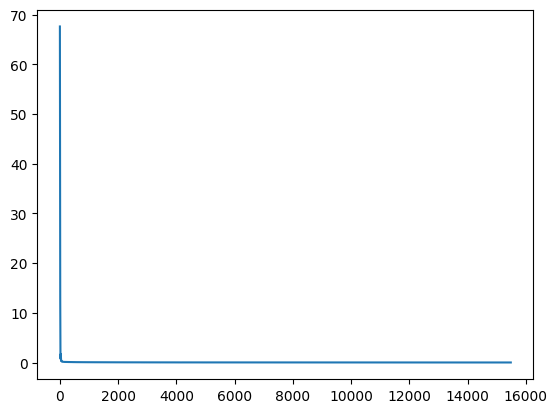

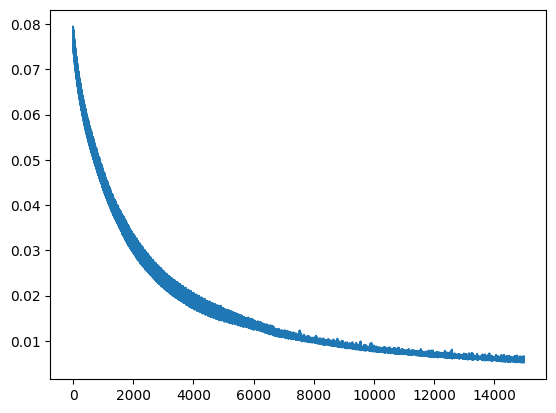

In [28]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

latter_training = mm_losses[500:]
plt.plot(list(range(len(latter_training))), latter_training, label='MM')
plt.show()

In [29]:
s0_batch = [s0 for s0, _, _ in mm_validation_data]
s1_batch = [s1 for _, _, s1 in mm_validation_data]
a_batch = [a for _, a, _ in mm_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print("validation loss", loss.mean().item())

validation loss 0.020294588059186935


In [30]:
s0_batch = [s0 for s0, _, _ in mm_train_data]
s1_batch = [s1 for _, _, s1 in mm_train_data]
a_batch = [a for _, a, _ in mm_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print("training loss", loss.mean().item())



training loss 0.005733337253332138


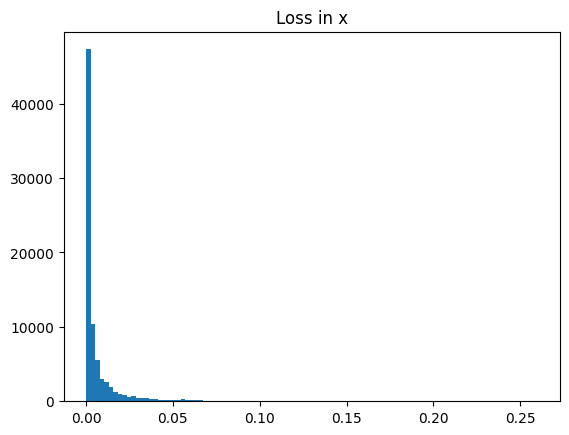

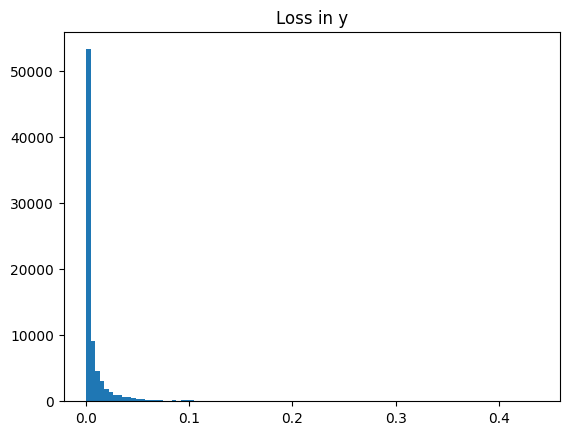

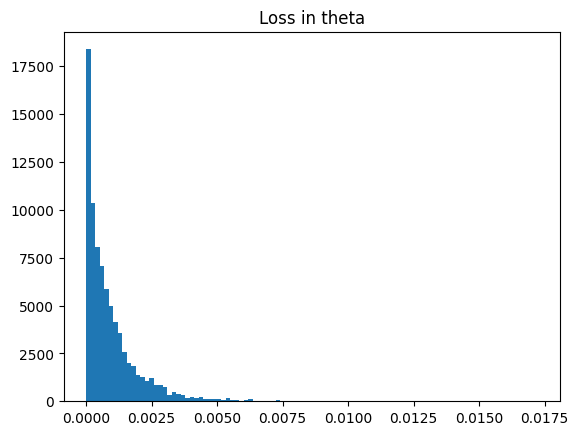

In [31]:
plt.hist(loss_x.cpu().detach().numpy(), bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y.cpu().detach().numpy(), bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta.cpu().detach().numpy(), bins=100)
plt.title('Loss in theta')
plt.show()


Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [11]:
from waymo_protos import scenario_pb2
# tensorflow don't allocate all gpu memory right away
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
import tqdm

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]


files = getFiles('~/data/waymo/')

def parse_scenario(scenario: scenario_pb2.Scenario) -> list[State]:
    states = []
    for s in scenario.tracks[scenario.sdc_track_index].states:
        if s.valid:
            states.append(State(s.heading, np.array([s.velocity_x, s.velocity_y], dtype=np.float32)))
    return states


h: list[list[State]] = []

for file_path in tqdm.tqdm(files):
    for data in tf.data.TFRecordDataset(file_path, compression_type="").as_numpy_iterator():
        scenario = scenario_pb2.Scenario()
        scenario.ParseFromString(data)
        h.append(parse_scenario(scenario))


2023-08-11 22:47:16.225994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 22:47:17.379143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  0%|          | 0/100 [00:00<?, ?it/s]2023-08-11 22:47:18.204849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-11 22:47:18.224628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at l

KeyboardInterrupt: 

In [86]:
idm_train_data: list[Observation] = []
for states in h:
    for i in range(len(states)-1):
        idm_train_data.append((states[i], states[i+1]))

print("train data:", len(idm_train_data))

train data: 145374


In [87]:
import pickle
import os

# pickle the data
if not os.path.exists('data/idm_train_data.pkl'):
    with open('data/idm_train_data.pkl', 'wb') as f:
        pickle.dump(idm_train_data, f)

In [ ]:
import pickle
import os

if 'idm_train_data' not in locals():
    # load data (if exists)   
    with open('data/idm_train_data.pkl', 'rb') as f:
        idm_train_data = pickle.load(f)

In [123]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 768, 2) # Bx3x2 -> Bx768x1
        self.fc1 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc2 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx768x1
        x = torch.flatten(x, 1) # Bx768x1 -> Bx768
        x = F.relu(self.fc1(x)) # Bx768 -> Bx768
        x = self.fc2(x) # Bx768 -> Bx2
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_tensor, pred_action)

    loss = F.mse_loss(pred_s1, s1_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [136]:
# eliminate outliers from the training data
idm_train_data_filtered = [o for o in idm_train_data if np.linalg.norm(o[1].velocity - o[0].velocity) < 1 and abs(normalize_angle(o[1].heading - o[0].heading)) < 0.1] 
print(len(idm_train_data_filtered))

145331


In [137]:
idm_train_iter = itertools.cycle(idm_train_data_filtered)

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [1]:
set_lr(idm_optimizer, 5e-5)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 20000
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = 4096

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_batch = [next(idm_train_iter) for _ in range(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)]
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_batch,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 100 == 0:
        print(f"Step: {idm_step}, Loss: {loss:.4f}")

NameError: name 'set_lr' is not defined

In [31]:
# load idm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('data/idm.pth'))    

In [108]:
# save idm
if not os.path.exists('data/idm.pth'):
    torch.save(mm.state_dict(), 'data/idm.pth')

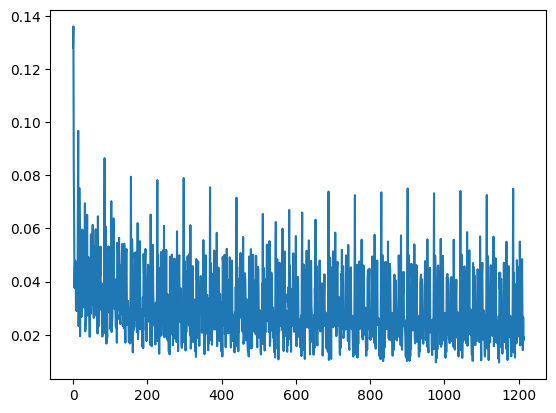

In [139]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

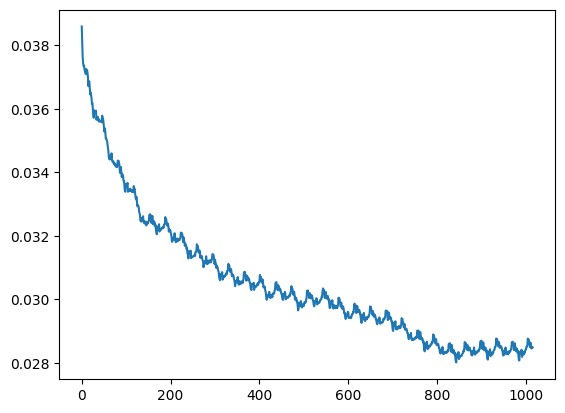

In [140]:
# compute running average of the last 200 episodes
# plot the average reward per episode
idm_losses_averaged = np.convolve(idm_losses, np.ones((200,))/200, mode='valid')
plt.plot(idm_losses_averaged)

Let' compare our trained IDM against the null idm (predicts 0 for all values):

In [107]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.021111002191901207


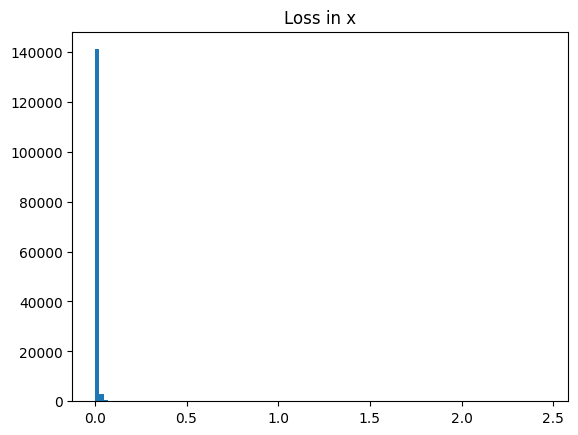

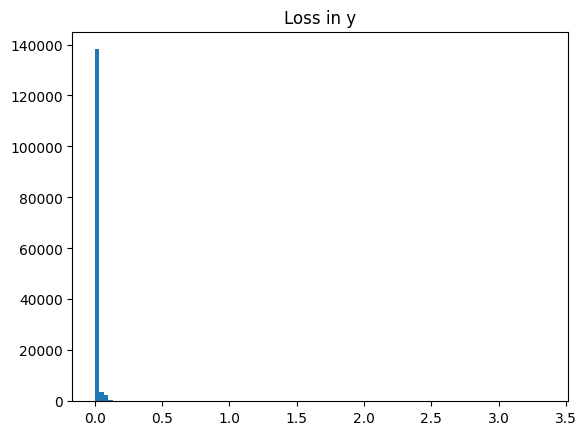

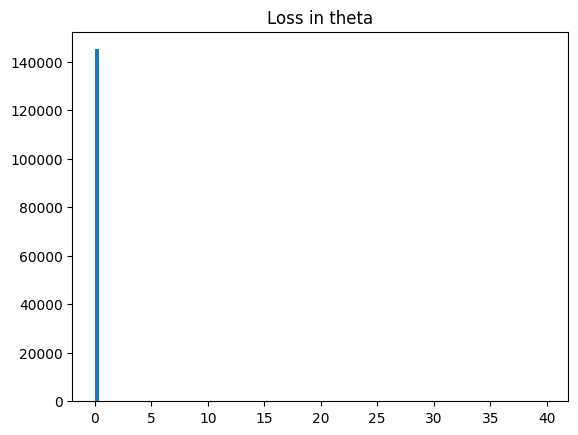

In [109]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


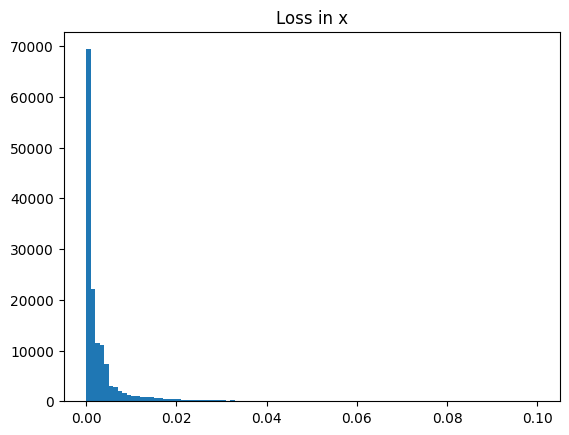

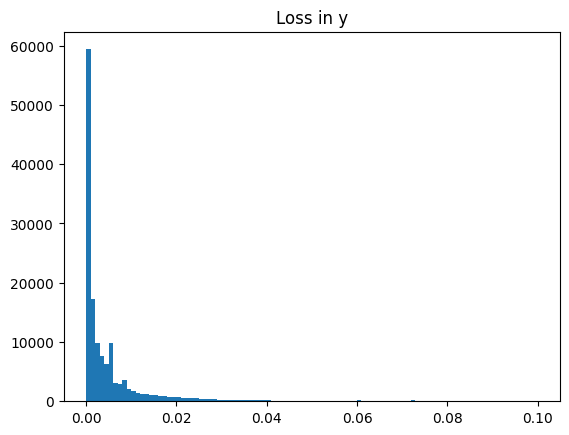

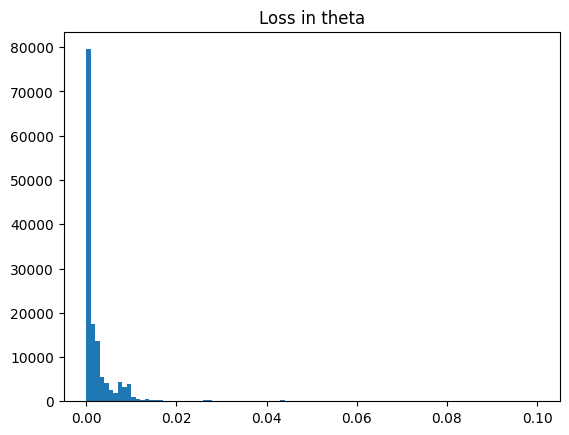

In [110]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()


Let's try visualizing our IDM by having it follow a track from start to finish.

In [30]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [63]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

In [103]:
scenario = h[1]
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)((st0, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

(-0.26485002040863037, 0.10388533025979996)
[ 0.02841214 -0.00302272] -0.0067837370867041 [-0.00011083  0.00087215] -0.006744205020368099
(-0.265168696641922, 0.10396337509155273)
[ 0.05668601 -0.00654016] -0.007005045773290419 [-4.3405351e-05  4.2588715e-04] -0.006743049249053001
(-0.26631584763526917, 0.10402288287878036)
[ 0.08499093 -0.00989405] -0.007425958383576514 [-2.9378416e-05 -8.2612707e-04] -0.006743814796209335
(-0.26619845628738403, 0.1039656475186348)
[ 0.11327186 -0.01319355] -0.008048871762546206 [-0.00035727 -0.00052484] -0.006743430159986019
(-0.2659027874469757, 0.10410494357347488)
[ 0.14157072 -0.01657832] -0.008879778022651053 [-0.00022116 -0.00028629] -0.006743430159986019
(-0.26654890179634094, 0.1041523814201355)
[ 0.16985378 -0.02011361] -0.00992493559245311 [-1.9360607e-05 -1.0560933e-03] -0.006743430159986019
(-0.26606789231300354, 0.10427597165107727)
[ 0.19816478 -0.02371274] -0.01118727394915009 [ 0.00028915 -0.00047262] -0.0068396818824112415
(-0.265030

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26490193605422974, 0.10394605994224548)
[ 0.74630147 -2.88626933] -1.1887261873227875 [-0.00030698  0.00092602] -0.006840062793344259


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26541244983673096, 0.10411699116230011)
[ 0.74158883 -2.916677  ] -1.2113798345033286 [0.00012035 0.00010053] -0.006838898174464703


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26667478680610657, 0.10416795313358307)
[ 0.70989454 -2.95328522] -1.2341139091487907 [ 0.00031894 -0.00123644] -0.006840062793344259


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2664116322994232, 0.10428915172815323)
[ 0.63323337 -2.86882806] -1.2570969893561736 [ 0.00053404 -0.00084201] -0.00684044323861599


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26566341519355774, 0.10431136190891266)
[ 0.66878992 -2.89260006] -1.2792933717775483 [ 8.818742e-04 -6.691119e-05] -0.00684044323861599


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2662629783153534, 0.10385673493146896)
[ 0.49779543 -2.94153452] -1.3004234244984545 [ 0.0002134  -0.00063383] -0.006841245573014021


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2666221559047699, 0.10399869084358215)
[ 0.34710705 -2.98692417] -1.321157997797485 [-0.00011517 -0.00102019] -0.006841245573014021


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26596391201019287, 0.1044604629278183)
[ 0.29740319 -3.00447917] -1.34086592249629 [ 0.00065714 -0.00043642] -0.0068416353315114975


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2650924324989319, 0.10428839921951294)
[ 0.35514143 -3.00994706] -1.3610505530302177 [0.00104358 0.00053029] -0.0068416353315114975


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2649482786655426, 0.10374326258897781)
[ 0.33351701 -3.04185319] -1.382482608218739 [0.00029575 0.00080775] -0.006842047907412052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26578909158706665, 0.10384231060743332)
[ 0.21112956 -3.07666969] -1.403533032423053 [-8.285345e-05 -1.941170e-04] -0.006842047907412052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2660520076751709, 0.10403531044721603)
[ 0.11352792 -3.10738921] -1.425480409282505 [-0.00013921 -0.0004483 ] -0.006842047907412052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26527777314186096, 0.10402125120162964)
[ 0.03543562 -3.13570356] -1.4486168875686776 [-0.00019597  0.00045057] -0.006842047907412052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.265004962682724, 0.10397890955209732)
[-0.04211082 -3.16269445] -1.4725587057684901 [-0.00015523  0.00066839] -0.006841245573014021


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2653026580810547, 0.10411965847015381)
[-0.13841149 -3.18571353] -1.4968512622838652 [0.00020758 0.00025023] -0.006841245573014021


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2650497555732727, 0.10439315438270569)
[-0.19010875 -3.19347858] -1.5225302604627364 [0.00105393 0.00045836] -0.006842047907412052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2653319537639618, 0.10391473770141602)
[-0.25372264 -3.19776845] -1.5506990479447227 [0.00064625 0.00031493] -0.006842442322522402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2664390504360199, 0.10377693176269531)
[-0.37474427 -3.21812677] -1.5800891611026193 [-9.729472e-05 -8.369428e-04] -0.006841648835688829


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2662047743797302, 0.1042475476861)
[-0.45072144 -3.23981047] -1.6066094518698462 [ 0.00020297 -0.00063461] -0.006842047907412052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2655865550041199, 0.10394632816314697)
[-0.53249723 -3.2565918 ] -1.63111452864021 [-0.00015697  0.00015632] -0.006842850707471371


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2651703953742981, 0.10377709567546844)
[-0.61763573 -3.26899862] -1.6549330424815523 [-0.00064566  0.00060508] -0.006842047907412052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26497262716293335, 0.10406788438558578)
[-0.70399928 -3.27876639] -1.6790724672342474 [-0.000275    0.00065401] -0.006842047907412052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26505976915359497, 0.10419587790966034)
[-0.79350317 -3.28585935] -1.7037407957794342 [0.00030363 0.00049132] -0.006841648835688829


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26550593972206116, 0.10365920513868332)
[-0.88358444 -3.29064298] -1.7288352300990333 [-0.00052204  0.00023692] -0.006841648835688829


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2653534710407257, 0.10383229702711105)
[-0.97393894 -3.293329  ] -1.7542116931780711 [-0.00080569  0.00037237] -0.006840855814516544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26531562209129333, 0.10472511500120163)
[-1.06563699 -3.29357815] -1.7797783059589403 [1.0118816e-03 1.7829565e-05] -0.006840855814516544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26563915610313416, 0.10426797717809677)
[-1.15915549 -3.2906158 ] -1.8055297421194618 [ 0.00130786 -0.00012748] -0.006842442322522402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26550379395484924, 0.10365889966487885)
[-1.2536217  -3.28467965] -1.831484643787265 [0.00014988 0.00029872] -0.006842442322522402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.265519917011261, 0.10383614152669907)
[-1.34934187 -3.27572227] -1.857635820427407 [-0.00027754  0.00016971] -0.006842442322522402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2657833993434906, 0.10395259410142899)
[-1.44638622 -3.26353455] -1.8839949899486843 [-0.00039166 -0.00015339] -0.006842442322522402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2657891809940338, 0.10383407771587372)
[-1.54407859 -3.24828672] -1.910569609202149 [-8.045055e-04 -6.968246e-05] -0.006841648835688829


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2654918134212494, 0.10398324579000473)
[-1.64226782 -3.23005795] -1.937339970795735 [-0.00075012  0.00019279] -0.006841250229626894


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2649697959423065, 0.10422494262456894)
[-1.74085104 -3.20883703] -1.964281573647412 [-7.3770221e-05  6.3877896e-04] -0.006840855814516544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2648908495903015, 0.10434159636497498)
[-1.84038866 -3.18404746] -1.9913856293255847 [0.00080008 0.00061578] -0.006841250229626894


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2656238079071045, 0.10388243943452835)
[-1.94130147 -3.15496325] -2.0186920852466024 [ 3.8014582e-04 -1.1530892e-05] -0.006841250229626894


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2657850980758667, 0.1037309542298317)
[-2.04234123 -3.12246847] -2.046237160401292 [-4.1160005e-04 -4.7299767e-05] -0.006841250229626894


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2655502259731293, 0.10441064834594727)
[-2.14331198 -3.08688593] -2.0739936905465344 [ 5.186278e-04 -6.396899e-05] -0.006841250229626894


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2654847502708435, 0.10416585206985474)
[-2.24439716 -3.04756975] -2.101938772496954 [0.00069232 0.00010433] -0.006842033937573433


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2657720446586609, 0.10363311320543289)
[-2.34577107 -3.00405335] -2.130082526264693 [-3.6835697e-04 -8.0475820e-06] -0.006842033937573433


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2656370997428894, 0.10355792194604874)
[-2.44678283 -2.95696092] -2.158433473965241 [-0.00137132  0.00020138] -0.006841250229626894


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26588135957717896, 0.10413825511932373)
[-2.54793024 -2.90582681] -2.1869836261153264 [-0.00082564 -0.00033226] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2658681273460388, 0.10442043840885162)
[-2.6485796  -2.85100245] -2.215742570094874 [ 0.00014294 -0.00038392] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26582419872283936, 0.10394202917814255)
[-2.74854302 -2.79219556] -2.2447004522078506 [-0.00018836 -0.00013537] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26606589555740356, 0.10399003326892853)
[-2.8480494  -2.72910595] -2.27385887035091 [-0.00031404 -0.00045002] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.265733540058136, 0.10428599268198013)
[-2.94638276 -2.66256309] -2.3032178245240527 [ 0.00022785 -0.00016888] -0.006840855814516544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26576030254364014, 0.10412781685590744)
[-3.04384685 -2.59170294] -2.3327578736513206 [ 0.00033951 -0.00017028] -0.006840855814516544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2657526135444641, 0.1038634330034256)
[-3.14008307 -2.5167129 ] -2.362489936693183 [-1.6950458e-04 -4.9247486e-05] -0.006840855814516544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2658819556236267, 0.10397998243570328)
[-3.23511147 -2.43746567] -2.3924188073396024 [-0.00029182 -0.00025103] -0.006840855814516544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26550188660621643, 0.10412786155939102)
[-3.32834196 -2.35471272] -2.422539425584508 [-5.7669287e-05  1.3378801e-04] -0.006840855814516544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2648265063762665, 0.10399132966995239)
[-3.41955352 -2.26847696] -2.4528150398048556 [-6.0550297e-05  8.9693913e-04] -0.006840855814516544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2647942304611206, 0.10394485294818878)
[-3.5091691  -2.17765212] -2.4832351305143403 [-3.1229192e-05  8.6369703e-04] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26545342803001404, 0.10396935790777206)
[-3.59723186 -2.08168197] -2.5138508304058913 [-1.2987649e-05  1.2250974e-04] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2657284736633301, 0.10376321524381638)
[-3.68297982 -1.98166037] -2.5447051495311133 [-6.1638583e-04 -8.8030774e-06] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26532793045043945, 0.10410375148057938)
[-3.76605558 -1.87854242] -2.575768393643852 [-0.0003075   0.00031368] -0.0068396818824112415


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2650976777076721, 0.10448765754699707)
[-3.8465991  -1.77159917] -2.607000082695538 [0.00087404 0.00036331] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2654940187931061, 0.10382495075464249)
[-3.9244566  -1.65978003] -2.6384167282849305 [0.00027452 0.00018609] -0.006840076297521591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26545077562332153, 0.10378135740756989)
[-3.99925685 -1.54430115] -2.670042964652112 [-0.00031777  0.00028146] -0.006840076297521591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26545393466949463, 0.10436612367630005)
[-4.0710535  -1.42499185] -2.7018632123047057 [5.571292e-04 2.251107e-05] -0.006840076297521591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26624158024787903, 0.10389665514230728)
[-4.13958168 -1.30065954] -2.733899974953923 [ 6.8562724e-05 -6.3349580e-04] -0.006840076297521591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26620009541511536, 0.10376990586519241)
[-4.20435524 -1.17332804] -2.7661773542076284 [-0.00070903 -0.0004498 ] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26531386375427246, 0.10423022508621216)
[-4.26531076 -1.04386795] -2.798633831044642 [-0.00017064  0.00032766] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26481765508651733, 0.1040443480014801)
[-4.32232571 -0.91088182] -2.83121015013071 [6.084066e-06 8.625845e-04] -0.006840076297521591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26527300477027893, 0.10396794229745865)
[-4.37531281 -0.77311653] -2.8639417315083286 [2.7668682e-05 3.2358294e-04] -0.006840076297521591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26594507694244385, 0.10422410070896149)
[-4.42406178 -0.63114953] -2.896899015788332 [ 0.00047243 -0.00047266] -0.006840076297521591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26625898480415344, 0.1042754277586937)
[-4.46827221 -0.48607233] -2.9301065040527474 [ 0.00076892 -0.00075717] -0.006840076297521591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2656763792037964, 0.10407394915819168)
[-4.50774527 -0.3393507 ] -2.96352171888219 [5.424480e-04 8.052971e-06] -0.006841250229626894


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26554667949676514, 0.1038849875330925)
[-4.54228783 -0.18947698] -2.9970917965290202 [8.5231295e-05 1.4751752e-04] -0.006840850692242384


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2657356560230255, 0.10399738699197769)
[-4.57174587 -0.03627852] -3.0308393738625043 [-8.0411846e-06 -1.2176326e-04] -0.006841250229626894


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26554790139198303, 0.10409298539161682)
[-4.59603643  0.11920065] -3.0647778998461472 [1.0346689e-04 7.8772784e-05] -0.006840850692242384


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2656562924385071, 0.10380365699529648)
[-4.61477184  0.2774837 ] -3.098896455519479 [-4.3643010e-04  5.7880927e-05] -0.006841250229626894


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2651437819004059, 0.10395503789186478)
[-4.62815905  0.43707356] -3.133190912982811 [-0.00047605  0.00057274] -0.006840076297521591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26477381587028503, 0.10416632890701294)
[-4.63593721  0.59857059] 3.1155581234053966 [9.0125388e-05 8.3420496e-04] -0.006840076297521591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2653438448905945, 0.1041654497385025)
[-4.63745165  0.76332575] 3.080952475568689 [0.00052788 0.00016182] -0.006839686073362827


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26592057943344116, 0.10401453822851181)
[-4.63265324  0.93032104] 3.0461123363979996 [ 0.00036219 -0.00034261] -0.006840850692242384


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26638224720954895, 0.10386092960834503)
[-4.62148428  1.09894013] 3.0110218600848433 [-0.00023936 -0.00072961] -0.006840850692242384


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26555463671684265, 0.10405591130256653)
[-4.60474157  1.26685512] 2.975724322996933 [-0.00026749  0.00016118] -0.006840850692242384


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2642824649810791, 0.10431171953678131)
[-4.58227444  1.43434691] 2.940327849474526 [0.00054828 0.00136449] -0.006840850692242384


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2649933993816376, 0.10400635749101639)
[-4.55206251  1.60495281] 2.904828711092097 [0.00064684 0.00055302] -0.006840451620519161


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2654021382331848, 0.10381755232810974)
[-4.51489687  1.77633631] 2.869109462445573 [0.00012179 0.00027244] -0.006840451620519161


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2662466764450073, 0.10405222326517105)
[-4.47038841  1.94888449] 2.833142007185453 [ 0.00012429 -0.00072972] -0.006840451620519161


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26612189412117004, 0.10391552746295929)
[-4.41949034  2.12029815] 2.796922616886212 [-0.00034774 -0.00041495] -0.006840850692242384


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2659289836883545, 0.1040143147110939)
[-4.36184311  2.2909708 ] 2.760514408465684 [-0.00042106 -0.00027321] -0.006840451620519161


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2660191059112549, 0.10403884202241898)
[-4.29690361  2.46127224] 2.723930830887375 [-0.00040534 -0.00039978] -0.006840850692242384


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2664889693260193, 0.10388839989900589)
[-4.22419786  2.63130021] 2.687144986224274 [-0.00079325 -0.00084376] -0.006840850692242384


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2648535668849945, 0.1045340746641159)
[-4.14663458  2.79757357] 2.650194158731642 [0.00041798 0.00075665] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2624879479408264, 0.10404124110937119)
[-4.0638175   2.96012568] 2.6132531849350444 [0.00072305 0.00340131] -0.006840451620519161


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26580411195755005, 0.10318772494792938)
[-3.96754265  3.12696552] 2.5762311178832533 [-0.00077291 -0.00023762] -0.0068396530114114285


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26459985971450806, 0.10416924953460693)
[-3.86772251  3.28830314] 2.538876155695202 [-0.00026201  0.0011251 ] -0.006839686073362827


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2670150399208069, 0.10404807329177856)
[-3.75669503  3.45051336] 2.501294425340331 [-0.00011549 -0.00167918] -0.006839253939688206


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2659029960632324, 0.10408647358417511)
[-3.64187813  3.60684824] 2.463395379341577 [-0.00029727 -0.00013081] -0.006840466056019068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2656281292438507, 0.10449334233999252)
[-3.51974869  3.76023889] 2.4253607784433378 [ 0.00077411 -0.00017857] -0.006838515866547823


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2673795521259308, 0.10379265993833542)
[-3.38721323  3.91200829] 2.3871176520317454 [-0.00012636 -0.00183553] -0.006841250229626894


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2616420090198517, 0.10342538356781006)
[-3.25804925  4.0531168 ] 2.348765935226705 [-0.00145812  0.00491761] -0.006839295849204063


In [113]:
env.close()

In [114]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

In [116]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0, s1 = o
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred


In [120]:
idm_test_set = random.sample(idm_train_data, 500)

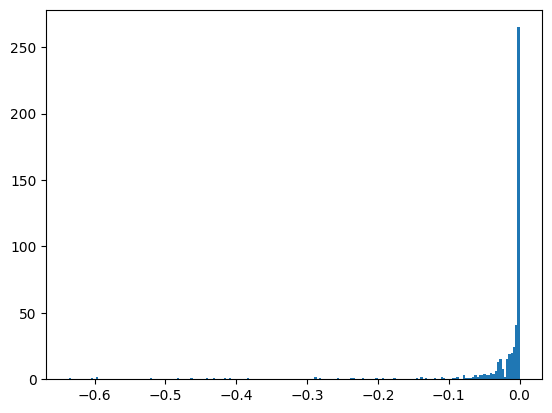

mean -0.028576100198793006
median -0.002603338107250909


In [121]:
def null_policy(_:Observation) -> tuple[float, float]:
    return 0, 0

# test loss function
do_nothing_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, null_policy, (s0, s1))
    do_nothing_loss.append(rew)

plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

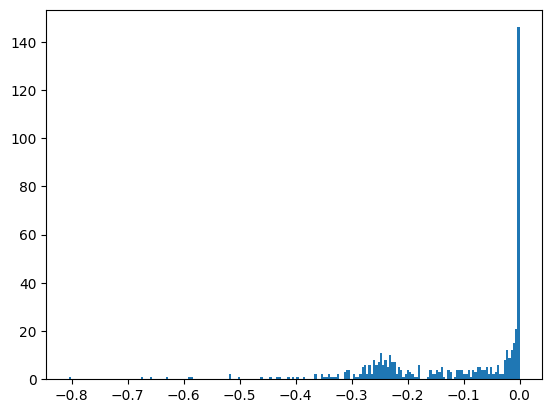

mean -0.1180650003180948
median -0.059890544769290344


In [141]:
# test loss function
idm_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), (s0, s1))
    idm_loss.append(rew)

plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))